<font color='Black' size=4><b>
Описание проекта
    
В нашем распоряжении исторические данные о продажах компьютерных игр по всему миру за период до 2016 г. На основе имеющейся информации необходимо дать прогноз на 2017 г. Требуется выполнить предобрабоку данных, исследовательский анализ и проверку гипотез.
    
В ходе проводимого исследования необходимо ответить на вопрос, какую рекламную стратегию выбрать. На какие платформы, с каким жанром, с каким рейтингом ESRB и в каком регионе увеличить рекламный бюджет? Стоит ли обращать внимание на отзывы или нет?     </b></font><br>

## 1 Откроем файл. Изучим общую информацию

In [1]:
# импортируем библиотеку pandas
import pandas as pd

# и ещё полезные библиотеки
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# сохраним данные из файла games.csv в переменную data
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
# изучим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# посмотрим начало датасета и название колонок
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
# посмотрим наличие явных дубликатов
data.duplicated().sum()

0

## 2 Предобработка данных

### 2.1 Переименование столбцов

In [6]:
# приведём названия стобцов к нижнему регистру
data.columns = data.columns.str.lower()

### 2.2 Преобразуйте данные в нужные типы

Пойдём слева направо. К первым двум столбцам замечаний нет, тип `object` оставляем. `year_of_release` преобразуем в целое число.

Если в столбце есть пропуски, метод `astype(int)` выдаст ошибку.

In [7]:
# создадим переменную skip, которая будет содержать пропуски

skip = pd.DataFrame(data.isna().sum()) \
    .rename(columns={0: 'before'})
skip

,before
name,2
platform,0
year_of_release,269
genre,2
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,8578
user_score,6701


269 пропусков в колонке год релиза.

Убрать эти пропуски можно тремя способами:
- удалить
- заполнить нулями
- с помощью wikipedia вручную заполнить все значения

Для принятия решения посмотрим какие данные есть в колонке `year_of_release`

In [8]:
# выведем отсортированные по возрастанию уникальные значения
data.year_of_release.sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

In [9]:
# число уникальных значений
len(data.year_of_release.sort_values().unique())

38

In [10]:
# число релизов игр каждый год
data.year_of_release.value_counts()

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      62
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: year_of_release, dtype: int64

<AxesSubplot:>

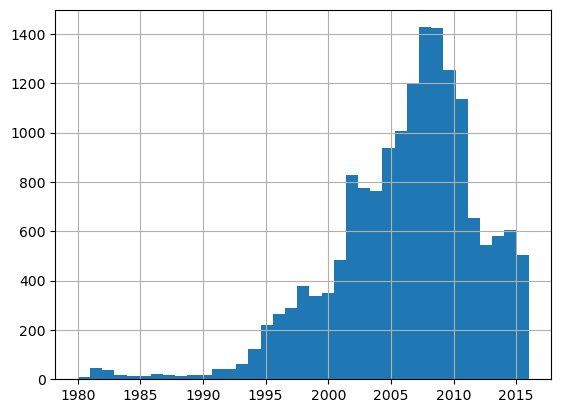

In [11]:
# построим гистограмму
data.year_of_release.hist(bins = 37)

В полученном датасете преимущественно игры с 2005 по 2011 г.

### 2.3 Заполним пропуски

Заполнить пропуски ни медианным ни средним значением нельзя. Попробуем год релиза связать с игровой платформой.

In [12]:
# создадим переменную game_count, которая содержит платформу и число вышедших игр 
game_count = data.groupby('platform', as_index=False) \
    .agg({'na_sales': 'count'}) \
    .rename(columns={'na_sales': 'games'})

In [13]:
# создадим переменную year, которая будет содержать данные о годах релиза игр для каждой игровой платформы
year = data.groupby('platform', as_index=False) \
    .agg({'year_of_release': ('min', 'max', 'mean', 'median')})

# избавимся от мультииндекса
year.columns = year.columns.get_level_values(0)

# вещественные числа преобразуем в целые
year = year.astype({'year_of_release':'int'},errors='ignore')

In [14]:
# переименуем колонки
new_col = ['platform', 'min', 'max', 'mean', 'median']
year.columns = new_col

In [15]:
# объеденим два источника 
year = year.merge(game_count)
year['period'] = year['max'] - year['min']
year.sort_values(by='period', ascending=False)
year.head()

,platform,min,max,mean,median,games,period
0,2600,1980,1989,1982,1982,133,9
1,3DO,1994,1995,1994,1995,3,1
2,3DS,2011,2016,2013,2013,520,5
3,DC,1998,2008,1999,2000,52,10
4,DS,1985,2013,2008,2008,2151,28


In [16]:
# посчитаем % пропусков в годе релиза
print((data.year_of_release.isna().sum()/data.year_of_release.shape *100).round(2), '%')

[1.61] %


In [17]:
# исключим строки со значением NaN в годе релиза
data = data[data['year_of_release'].notna()]

In [18]:
# теперь мы готовы сменить формат flat на int
data['year_of_release'] = data['year_of_release'].astype('int')

Изучим сведения об оценках пользователей

In [19]:
# посмотрим уникальные оценки
data.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [20]:
# посмотрим как распределены оценки
data.user_score.value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Помимо цифровых оценок, встречается tbd, т.е. рейтинг неизвестен, будет объявлен позже. Количество таких игр больше всего. У столбца `user_score` установлен тип `object`. Если изменим тип на float, потеряем ячейки с рейтингом tbd.

Посмотрим у каких игр рейтинг tbd.

======================================================================

Подслушано в slack. Пока не будем использовать

`data.year_of_release= round(data.year_of_release,0).astype('Int64')` 

Меняет тип на int, оставляя nan

======================================================================

In [21]:
data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


In [22]:
data.query('user_score == "tbd"').groupby('jp_sales')['jp_sales'].count()

jp_sales
0.00    2294
0.01      16
0.02      11
0.03      11
0.04       5
0.05       7
0.06       6
0.08       2
0.09       3
0.10       1
0.11       2
0.12       2
0.13       2
0.14       1
0.15       1
0.16       2
0.17       1
0.18       2
0.20       1
0.25       2
0.26       1
0.31       1
0.47       1
0.86       1
Name: jp_sales, dtype: int64

У игр с пользовательской оценкой tbd почти нет продаж в Японии

In [23]:
# изменим тип столбца оценок пользователей на float
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

<AxesSubplot:>

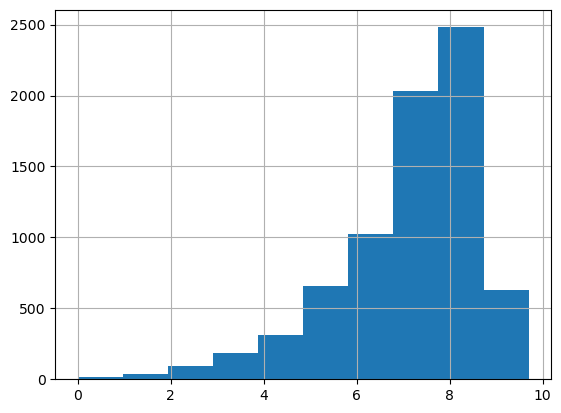

In [24]:
# теперь можно строить гистограмму
data.user_score.hist(bins=10)

<AxesSubplot:>

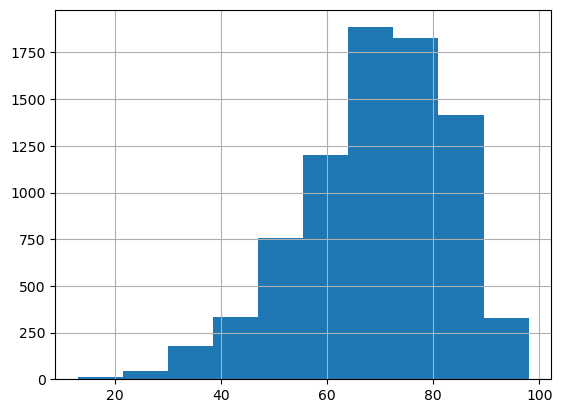

In [25]:
# столбец с оценкой критиков имеет тип float. Сразу построим гистограмму
data.critic_score.hist(bins=10)

Полученные гистограммы похожи. Методом describe оценим распределение оценок.


In [26]:
data.critic_score.describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [27]:
data.user_score.describe()

count    7463.000000
mean        7.126330
std         1.499447
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Критики используют 100 бальную систему оценки, пользователи - 10-ти. Видно, что пользовательские оценки немого выше оценок критиков. 

После преобразования колонки пользовательского рейтинга в float мы потеряли значения **tbd**, они стали **NaN**.

In [28]:
# удалим два пропуска в колонке Имя.
# вместо dropna() оставим те строки, в которых нет NaN
data = data[data['name'].notna()]

Остаётся 6766 пропусков в колонке `rating`. Имеющихся данных не достаточно, чтоб на основании них заполнить эти пропуски. Поставим заглушке для пропусков.

In [29]:
data.rating = data.rating.fillna('unknown')

Ранее была создана переменная skip. Добавим в неё колонку с информацией после заполнения пропусков.

In [30]:
# через промежуточную переменную skip_after получим столбец after
skip_after = pd.DataFrame(data.isna().sum()) \
    .rename(columns={0: 'after'})
skip['after'] = skip_after['after']
skip

,before,after
name,2,0
platform,0,0
year_of_release,269,0
genre,2,0
na_sales,0,0
eu_sales,0,0
jp_sales,0,0
other_sales,0,0
critic_score,8578,8461
user_score,6701,8981


###  2.4 Суммарные продажи во всех регионах

Создадим колонку `total_sales`, в которую поместим сумму продаж по всем регионам

In [31]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

<br> А можно использовать вот такой код:</font><br>
` = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)`

In [32]:
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name ['Wii Sports' 'Super Mario Bros.' 'Mario Kart Wii' ...
 'Woody Woodpecker in Crazy Castle 5' 'LMA Manager 2007'
 'Haitaka no Psychedelica']
name : ко

## 3 Исследовательский анализ данных

### 3.1 Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [33]:
# число релизов игр за каждый год
# ранее мы выводили этот список, но теперь в нём заполнены пропуски
data.year_of_release.value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

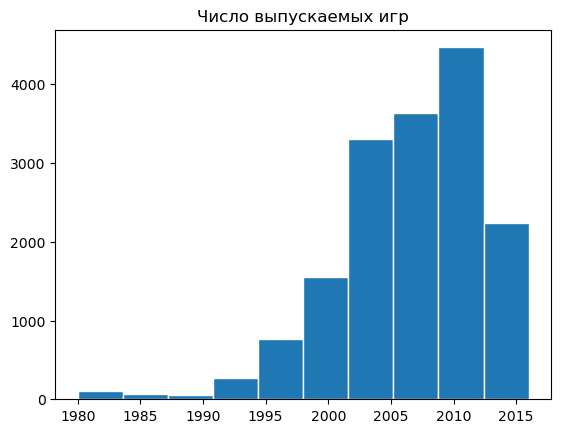

In [34]:
# построим гистограмму
data.year_of_release.hist(ec="white", grid=False).set_title('Число выпускаемых игр');

Исследуемый датафрейм демонстрирует ежегодный рост числа выпускаемых игр. Снижение количества игр после 2011 г. скорее всего связано с тем, что в представленном файле содержатся не все данные об играх.

Согласно <code>[статьи](https://www.igromania.ru/news/48878/Polzovateli_sostavlyayut_spisok_vseh_kogda-libo_vypuschennyh_igr.html?ysclid=l7dnc0vzi1157470999)</code> по состоянию на 2014 г. вышло 43 811 игр. Нам для анализа предоставлено 16 715 игр.

Полагаю, что для анализа интересен период с 1994 г. Ранее игр выпускалось совсем мало.

### 3.2 Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Для выполнения задачи будем использовать второй датафрейм `year`

In [35]:
# создадим переменную, которя будет содержать число проданных копий для каждой платформы
platform = data.groupby('platform')['total_sales'].sum().reset_index()

In [36]:
# добавим у year колонку с числом проданных копий
year = year.merge(platform)

In [37]:
# посмотрим топ 5 по сумме проданных копий, в млн
year.sort_values(by='total_sales', ascending=False).head()

,platform,min,max,mean,median,games,period,total_sales
16,PS2,2000,2011,2004,2005,2161,11,1233.56
28,X360,2005,2016,2009,2010,1262,11,961.24
17,PS3,2006,2016,2010,2011,1331,10,931.34
26,Wii,2006,2016,2008,2009,1320,10,891.18
4,DS,1985,2013,2008,2008,2151,28,802.78


Text(0.5, 1.0, 'Платформа PS2')

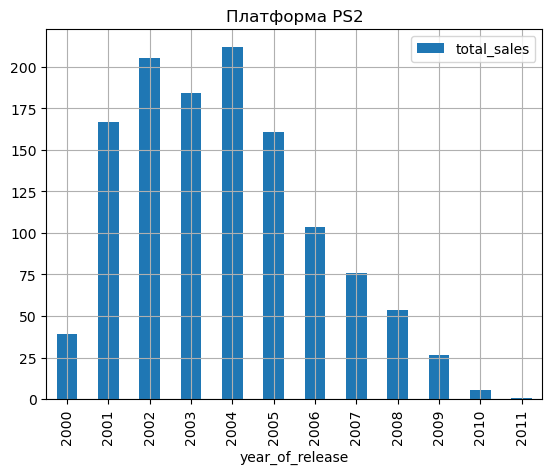

In [38]:
# построим график продаж для PS2 по годам
data.query('platform == "PS2"') \
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum') \
    .plot.bar(y='total_sales', grid=True);
plt.title('Платформа PS2')

Text(0.5, 1.0, 'Платформа X360')

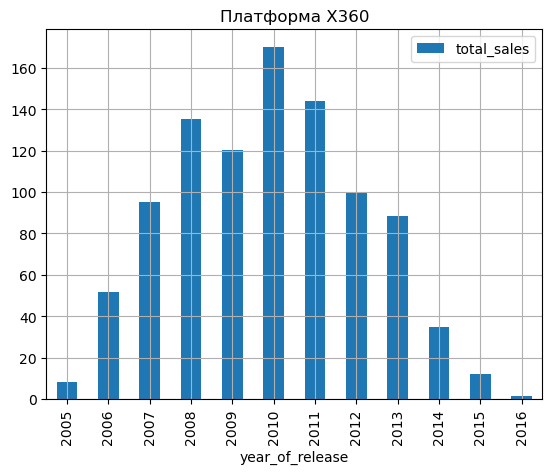

In [39]:
# построим график продаж для X360 по годам
data.query('platform == "X360"') \
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum') \
    .plot.bar(y='total_sales', grid=True);
plt.title('Платформа X360')

Text(0.5, 1.0, 'Платформа PS3')

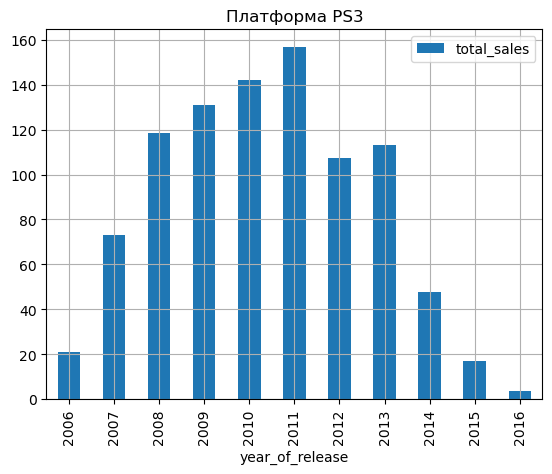

In [40]:
# построим график продаж для PS3 по годам
data.query('platform == "PS3"') \
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum') \
    .plot.bar(y='total_sales', grid=True);
plt.title('Платформа PS3')

Text(0.5, 1.0, 'Платформа Wii')

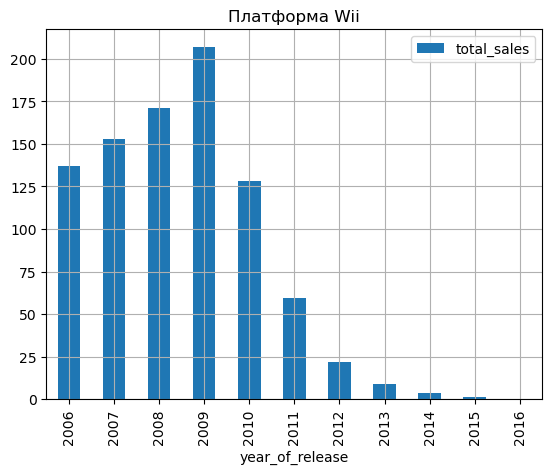

In [41]:
# построим график продаж для Wii по годам
data.query('platform == "Wii"') \
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum') \
    .plot.bar(y='total_sales', grid=True);
plt.title('Платформа Wii')

Text(0.5, 1.0, 'Платформа DS')

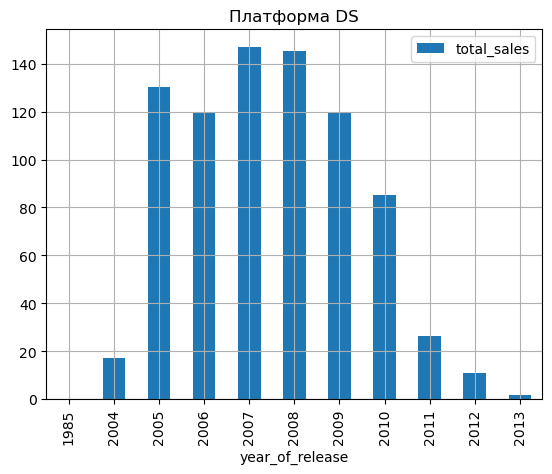

In [42]:
# построим график продаж для DS по годам
data.query('platform == "DS"') \
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum') \
    .plot.bar(y='total_sales', grid=True);
plt.title('Платформа DS')

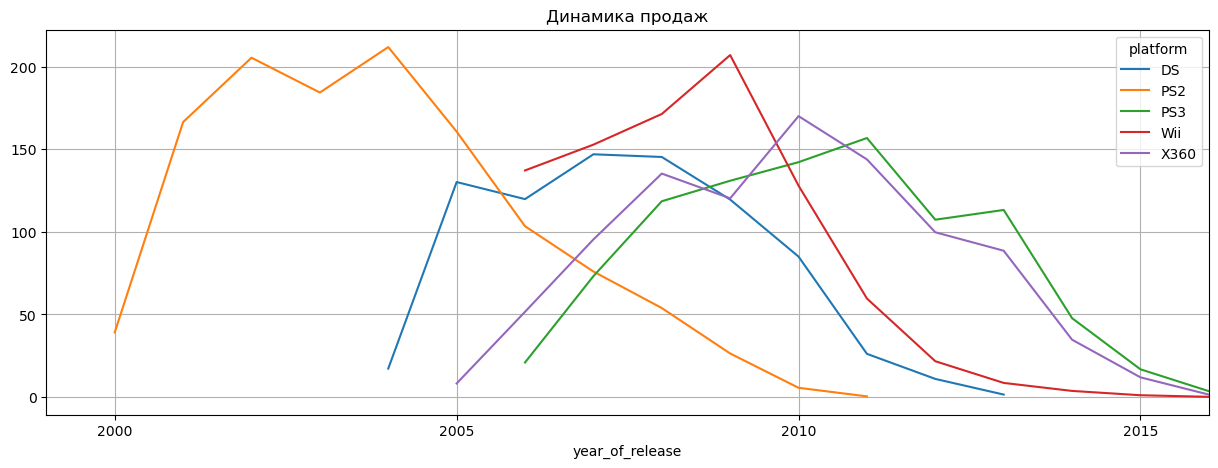

In [43]:
# построим график продаж для топ 5 платформ по годам
data.query('platform == ["PS2", "X360", "PS3", "Wii", "DS"]') \
    .pivot_table(index = 'year_of_release', columns ='platform', values = 'total_sales', aggfunc = 'sum') \
    .plot(grid=True, figsize=(15, 5));
plt.xlim([1999, 2016])
plt.xticks([2000, 2005, 2010, 2015])
plt.title('Динамика продаж');

График продаж у пяти самых популярных платформ показал, что у всех разная динамика роста и спада популярности.

Однако, можно заметить общий период жизни платформы ~10 лет.

### 3.2 Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Чтобы построить прогноз на 2017 год, создадим переменную содержащею данные за актуальный период. Актуальным будем считать данные за последние 3 года.

In [44]:
data_actual = data.query('year_of_release > 2013')

Text(0.5, 1.0, 'Динамика продаж')

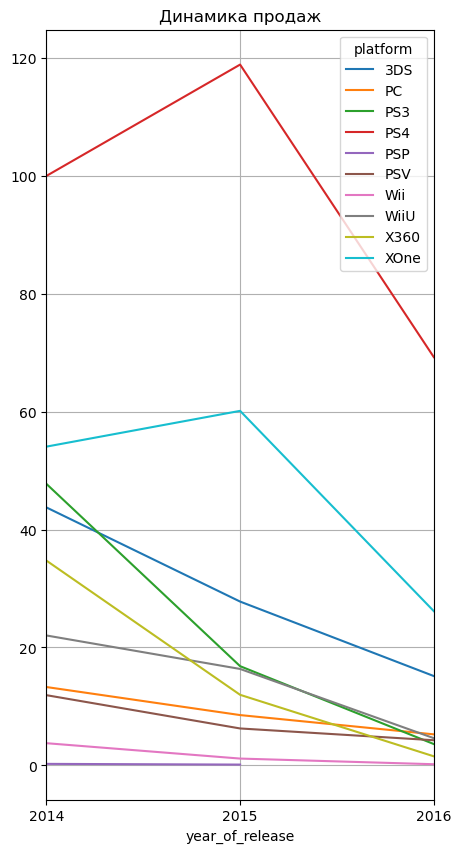

In [45]:
# построим график продаж
data_actual \
    .pivot_table(index = 'year_of_release', columns ='platform', values = 'total_sales', aggfunc = 'sum') \
    .plot(grid=True, figsize=(5, 10));
plt.xlim([2014, 2016])
plt.xticks([2014, 2015, 2016])
plt.title('Динамика продаж')

Почти все платформы показывают снижение объёма продаж. Или у нас не полные данные за 2016 год или все ждут выход **Xbox Series S** и **PlayStation 5**.

Платформа `PC` стабильна за последние 3 года, значит в 2017 году покажет суммарный объём продаж ~10 млн копий.

Поддержка `PlayStation Vita` прекратится в 2019 году, вероятно, суммарный объём продаж будет будет схожий с `PC` ~10 млн копий.

Платформа `WiiU` последние 2 года показывает подение продаж. В связи с тем, что в январе 2017 года прекратится поддержка, полагаю, что объём продаж составит не более 2 млн копий.

### 3.4 Не учитывайте в работе данные за предыдущие годы.

Данные исключены

### 3.5 Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Text(0.5, 1.0, 'Динамика продаж')

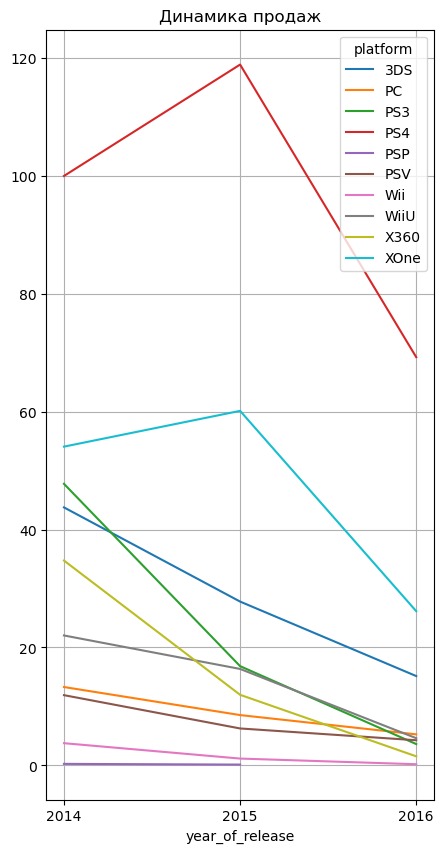

In [46]:
# повторно ознакомимся с графиком
# построим динамику продаж за актуаьный период

data_actual \
    .pivot_table(index = 'year_of_release', columns ='platform', values = 'total_sales', aggfunc = 'sum') \
    .plot(grid=True, figsize=(5, 10));
#plt.xlim([2010, 2016])
plt.xticks([2014, 2015, 2016])
plt.title('Динамика продаж')

Объём продаж у `PS4` и `XOne` упал в 2016 г. Однако, они остаются лидерами.

Потенциально прибыльными считаю те платформы, которые сделали наибольшее число продаж менее чем за 3 года

In [47]:
# выведем топ 3 таких платформ
year.query('period < 4').sort_values(by='total_sales', ascending=False).head(3)

,platform,min,max,mean,median,games,period,total_sales
18,PS4,2013,2016,2015,2015,392,3,314.14
30,XOne,2013,2016,2014,2015,247,3,159.32
22,SCD,1993,1994,1993,1994,6,1,1.86


Лучшие продажи у `PS4` и `XOne`.

### 3.6 Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Для построения ящика с усами вызовим boxplot. По оси Y - число проданных копий, по X - игровые платформы.

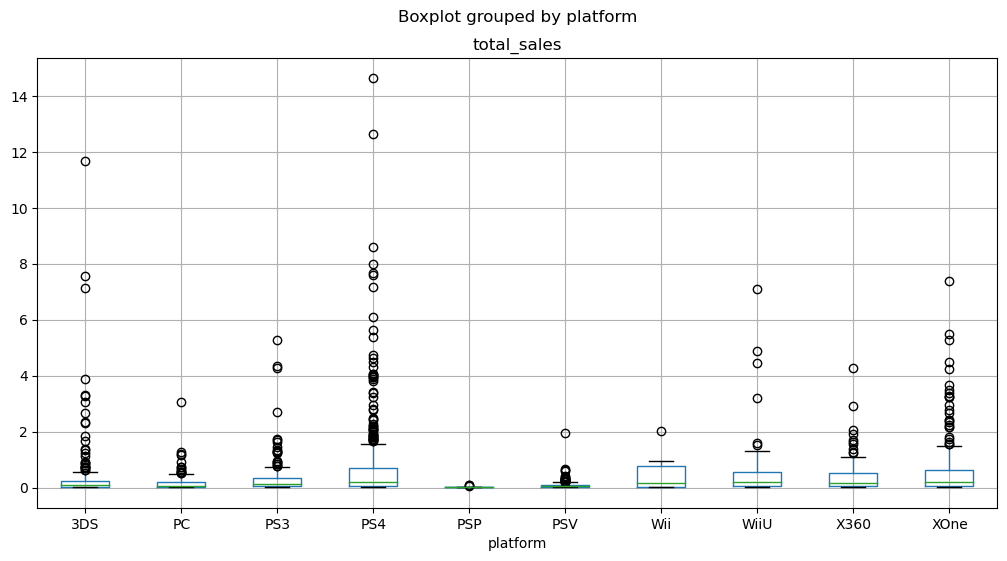

In [48]:
data_actual.boxplot('total_sales', by='platform', figsize=(12, 6));

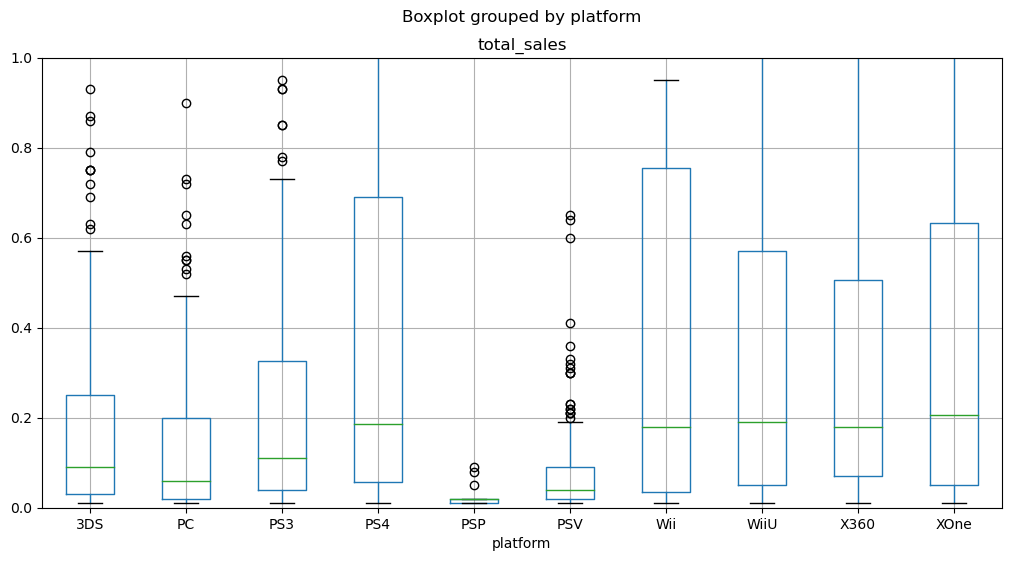

In [49]:
# установим лимит о оси Y
data_actual.boxplot('total_sales', by='platform', figsize=(12, 6)).set_ylim(0, 1);

У игровых платформ выпущено различное число игр, однако, видно, что медианное значение числа копий не превышает 0.5 млн

Если рассматривать выбросы в диаграмме размаха, можно увидеть платформы с числом продаж более 10 млн копий игр: `3DS`, `PS3`, `PS4`, `X360`.

### 3.7 Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [54]:
year = year.rename(columns = {'min' : 'min_year', 'max': 'max_year', 'mean': 'mean_year'})

Определим популярную платформу

In [56]:
# наибольшее число игр
year.query('min_year > 2011').sort_values(by = 'games').tail(1)

,platform,min_year,max_year,mean_year,median,games,period,total_sales
18,PS4,2013,2016,2015,2015,392,3,314.14


In [57]:
# наибольшее число продаж
year.query('min_year > 2011').sort_values(by = 'total_sales').tail(1)

,platform,min_year,max_year,mean_year,median,games,period,total_sales
18,PS4,2013,2016,2015,2015,392,3,314.14


Определено однозначно, **PS4** - самая популярная платформа.

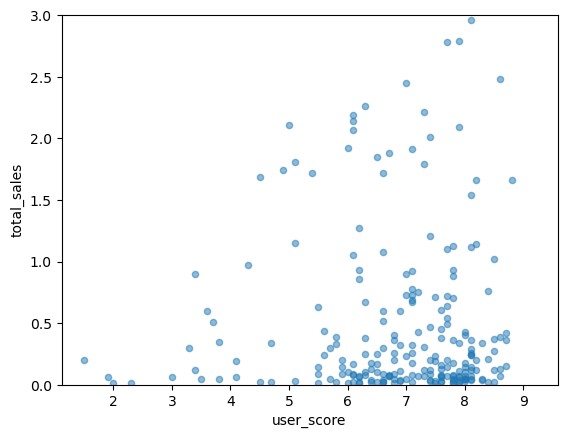

In [58]:
# Диаграмма рассеяния соотношения числа копий к отзывам пользователей
data_actual.query('platform == "PS4"') \
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 3);

In [59]:
data_actual.query('platform == "PS4" and user_score > 1')['user_score'].corr(data_actual['total_sales'])

-0.040131589472697356

Отрицательная корреляция означает, что изменение одной величины приводит противоположному изменению другой.

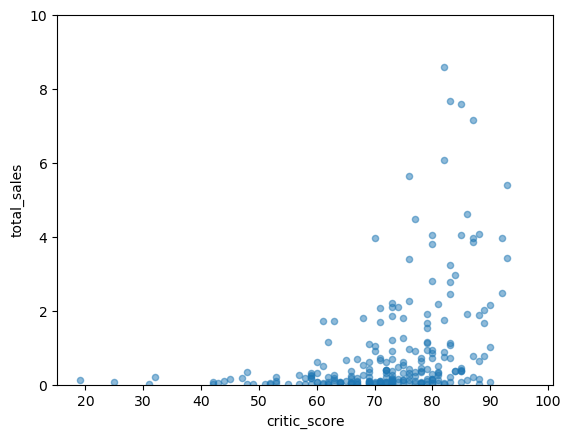

In [60]:
# Диаграмма рассеяния соотношения числа копий к отзывам критиков
data_actual.query('platform == "PS4"') \
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 10);

В случае с зависимостью объёма продаж с рейтингом критиков корреляция слабая

### 3.8 Соотнесите выводы с продажами игр на других платформах.

Проделаем предыдущий анализ для других популярных платформ.  
Выведем их список:

In [61]:
pd.DataFrame(
    data_actual.groupby('platform')['total_sales'] \
             .sum() \
             .reset_index() \
             .sort_values('total_sales', ascending=False) \
             .head()
            ).reset_index()

,index,platform,total_sales
0,3,PS4,288.15
1,9,XOne,140.36
2,0,3DS,86.68
3,2,PS3,68.18
4,8,X360,48.22


Text(0.5, 1.0, 'Диаграмма рассеяния для XOne')

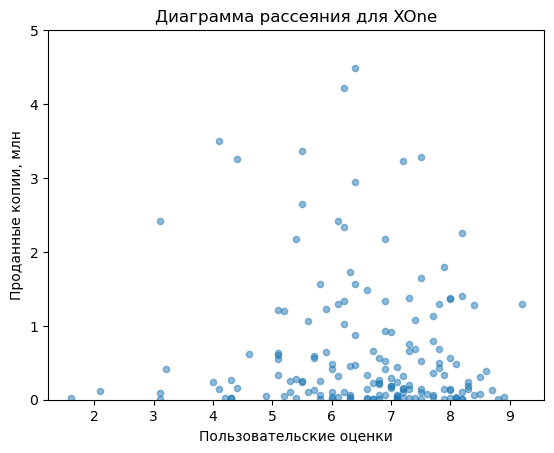

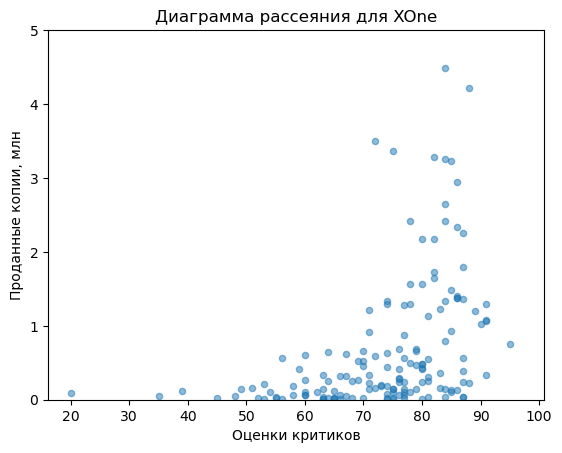

In [62]:
# построим для XOne
data_actual.query('platform == "XOne"') \
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Пользовательские оценки')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для XOne')

data_actual.query('platform == "XOne"') \
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Оценки критиков')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для XOne')

In [63]:
# корреляция XOne
print(data_actual.query('platform == "XOne" and user_score > 1')['user_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам пользователей')
print(data_actual.query('platform == "XOne" and user_score > 1')['critic_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам критиков')

-0.0703839280647581 корреляция по отношению к оценкам пользователей
0.42211185105557647 корреляция по отношению к оценкам критиков


Text(0.5, 1.0, 'Диаграмма рассеяния для PS3')

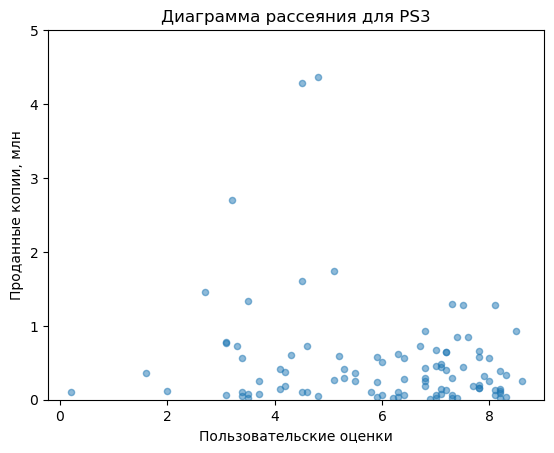

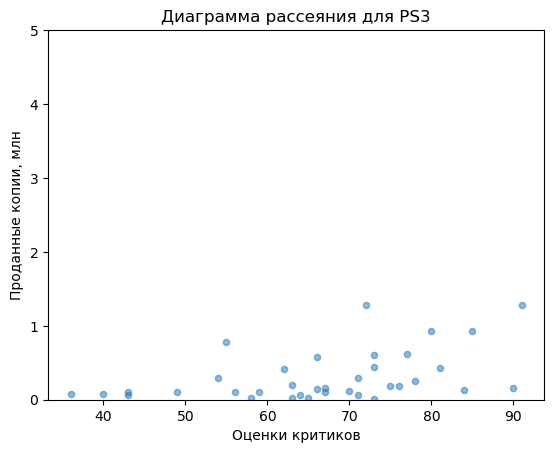

In [64]:
# построим для PS3
data_actual.query('platform == "PS3"') \
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Пользовательские оценки')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для PS3')

data_actual.query('platform == "PS3"') \
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Оценки критиков')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для PS3')

In [65]:
# корреляция PS3
print(data_actual.query('platform == "PS3" and user_score > 1')['user_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам пользователей')
print(data_actual.query('platform == "PS3" and user_score > 1')['critic_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам критиков')

-0.1950855092193697 корреляция по отношению к оценкам пользователей
0.44657460493190704 корреляция по отношению к оценкам критиков


Text(0.5, 1.0, 'Диаграмма рассеяния для X360')

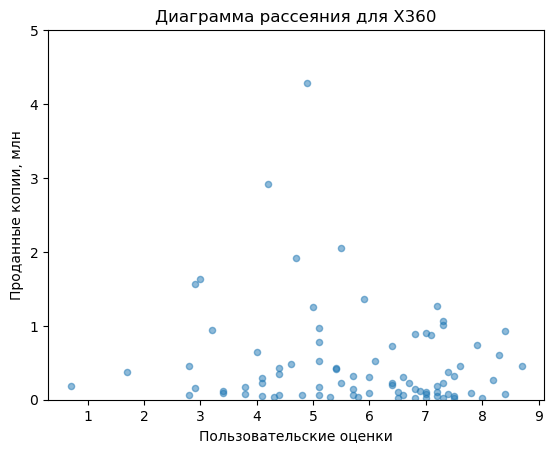

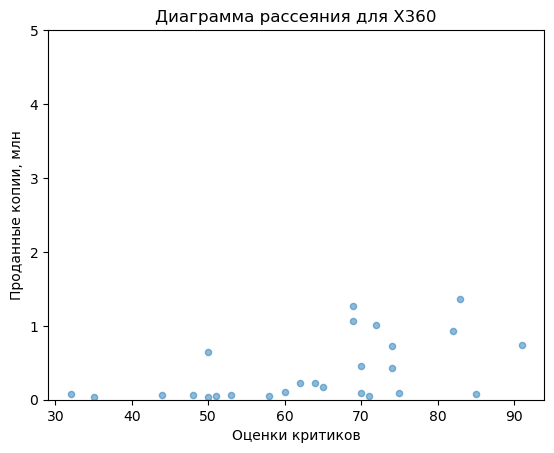

In [66]:
# построим для X360
data_actual.query('platform == "X360"') \
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Пользовательские оценки')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для X360')

data_actual.query('platform == "X360"') \
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Оценки критиков')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для X360')

In [67]:
# корреляция PS3
print(data_actual.query('platform == "X360" and user_score > 1')['user_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам пользователей')
print(data_actual.query('platform == "X360" and user_score > 1')['critic_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам критиков')

-0.1646211394968354 корреляция по отношению к оценкам пользователей
0.5257228356581523 корреляция по отношению к оценкам критиков


Text(0.5, 1.0, 'Диаграмма рассеяния для WiiU')

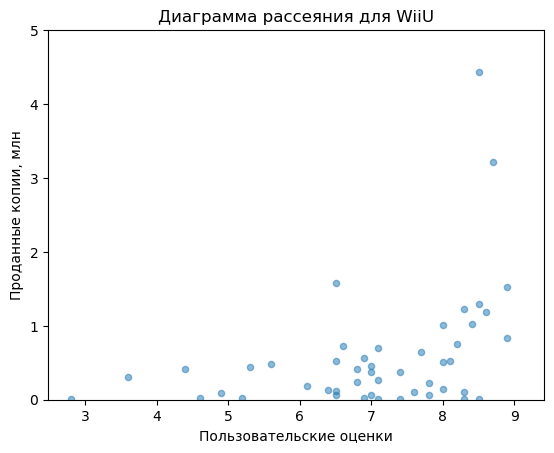

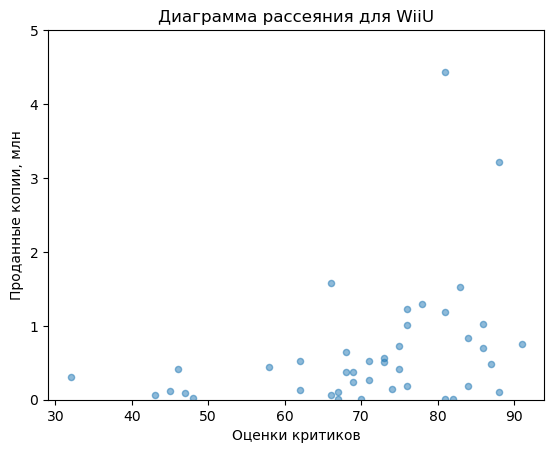

In [68]:
# построим для WiiU
data_actual.query('platform == "WiiU"') \
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Пользовательские оценки')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для WiiU')

data_actual.query('platform == "WiiU"') \
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.5) \
    .set_ylim(0, 5);
plt.xlabel('Оценки критиков')
plt.ylabel('Проданные копии, млн')
plt.title('Диаграмма рассеяния для WiiU')

In [69]:
# корреляция PS3
print(data_actual.query('platform == "WiiU" and user_score > 1')['user_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам пользователей')
print(data_actual.query('platform == "WiiU" and user_score > 1')['critic_score'] \
      .corr(data_actual['total_sales']), 'корреляция по отношению к оценкам критиков')

0.40792645792170773 корреляция по отношению к оценкам пользователей
0.3756402218389979 корреляция по отношению к оценкам критиков


Промежуточный вывод.  
Пользователи сами не знают чего хотят. А вот ревьювер Олег знает - чтобы Я внимательно читал задание и сделаланализ продаж в разрезе по платформам.

Действительно, объём продаж не имеет зависимости от пользовательских оценок. В большинстве случаев корреляция отрицательная.  
Связь числа проданных копий с рейтингом критиков - слабая.

Для формирования прогназа на 2017 г. не стоит принимать во внимание отзывы.

3DS


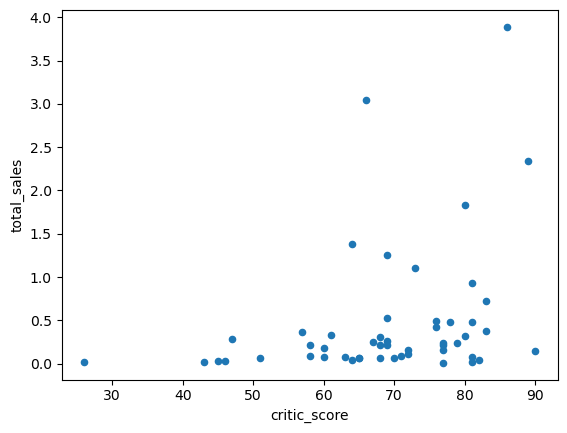

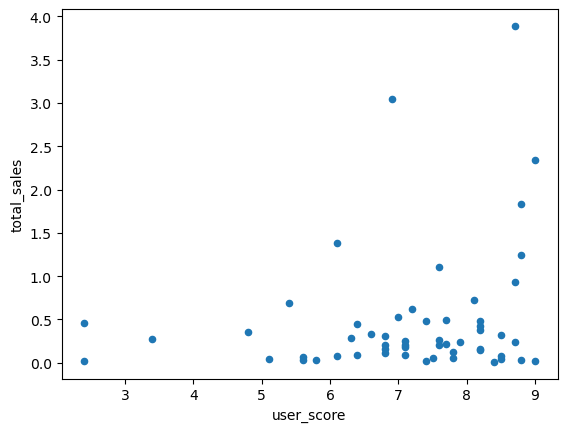

critic_score    0.314117
user_score      0.215193
total_sales     1.000000
Name: total_sales, dtype: float64

PC


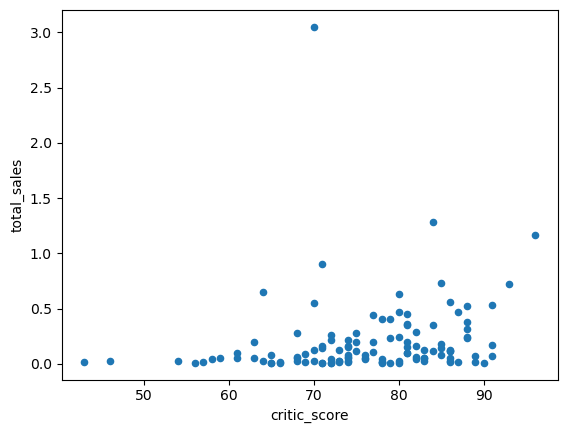

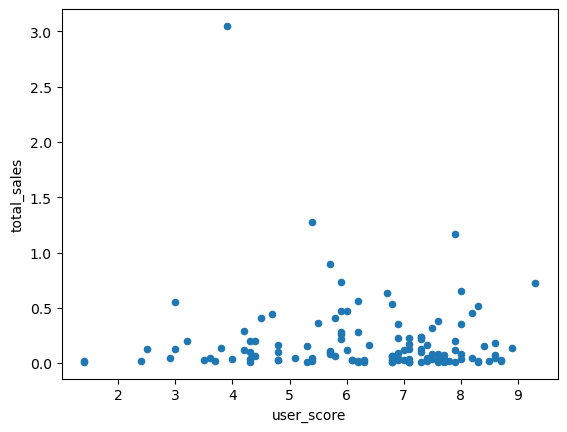

critic_score    0.174634
user_score     -0.071597
total_sales     1.000000
Name: total_sales, dtype: float64

PS3


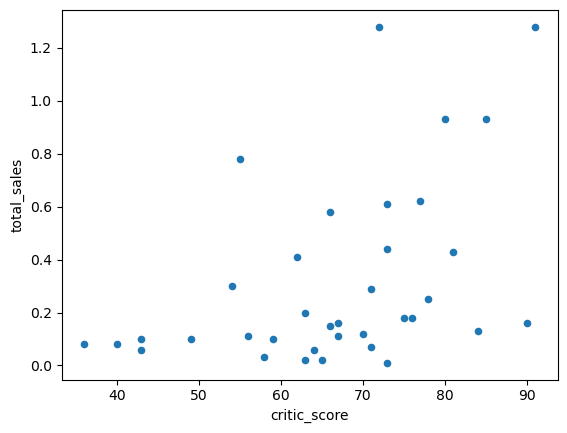

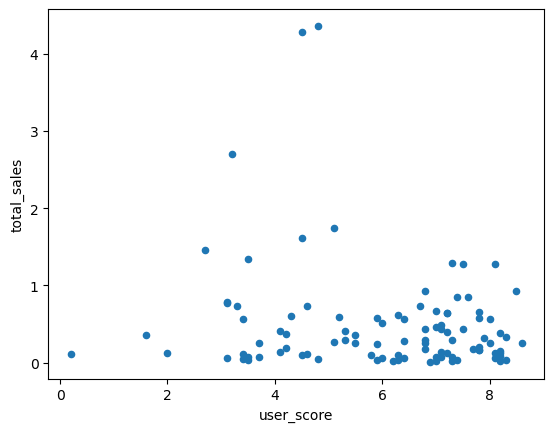

critic_score    0.446575
user_score     -0.166761
total_sales     1.000000
Name: total_sales, dtype: float64

PS4


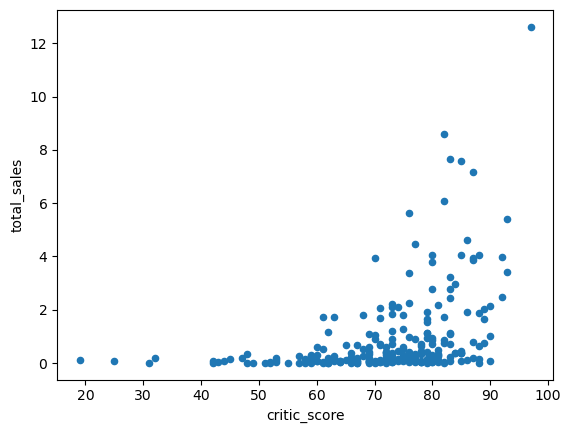

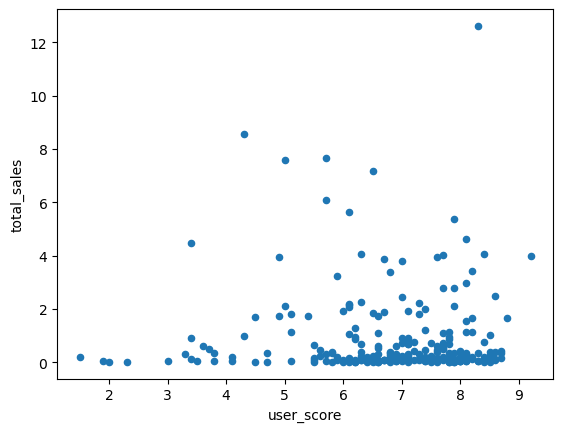

critic_score    0.402661
user_score     -0.040132
total_sales     1.000000
Name: total_sales, dtype: float64

PSP


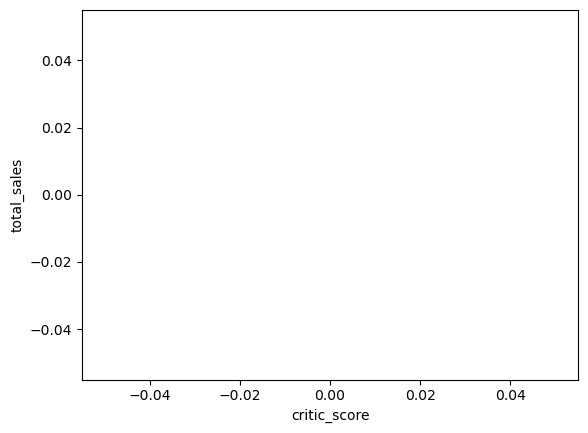

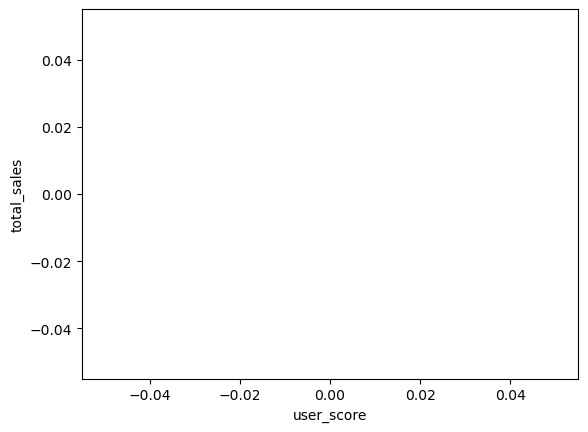

critic_score    NaN
user_score      NaN
total_sales     1.0
Name: total_sales, dtype: float64

PSV


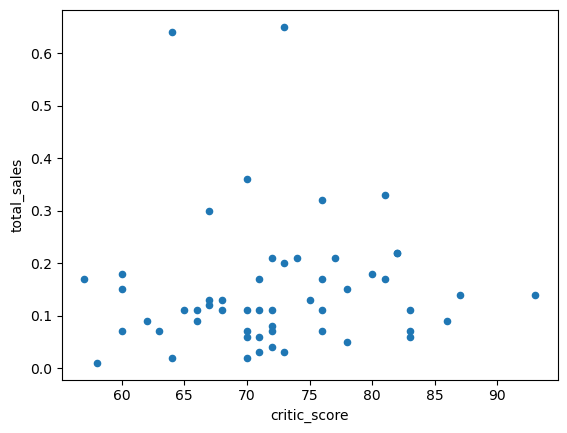

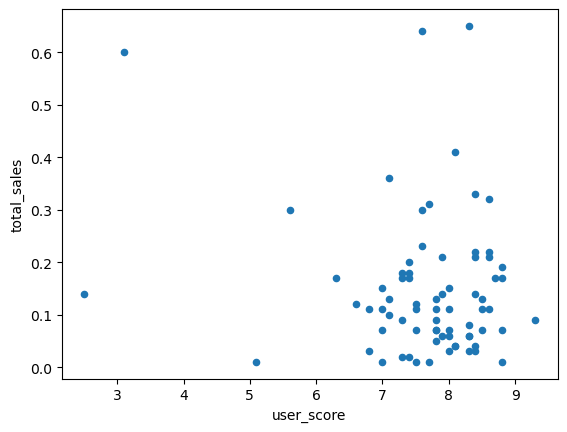

critic_score    0.042665
user_score     -0.168455
total_sales     1.000000
Name: total_sales, dtype: float64

Wii


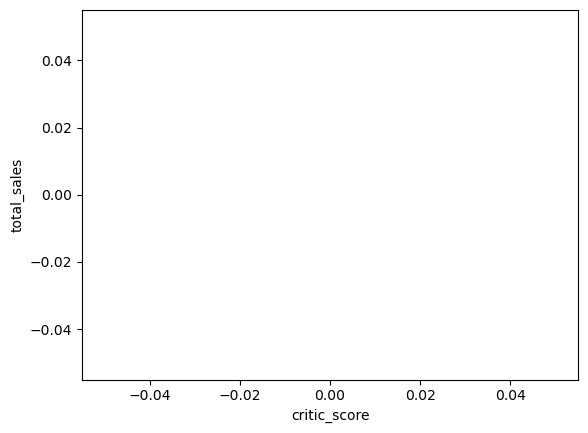

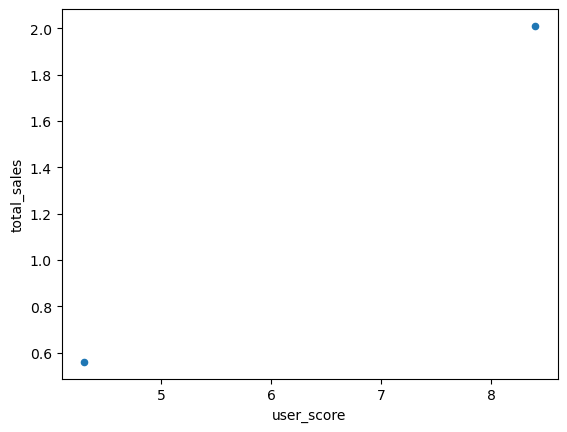

critic_score    NaN
user_score      1.0
total_sales     1.0
Name: total_sales, dtype: float64

WiiU


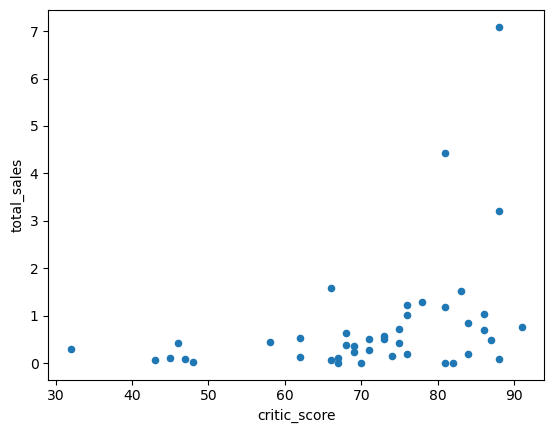

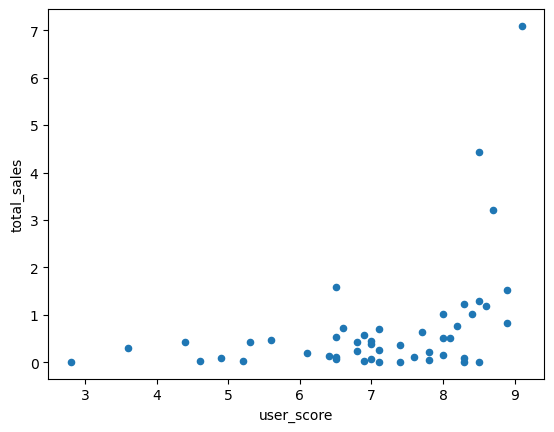

critic_score    0.370201
user_score      0.407926
total_sales     1.000000
Name: total_sales, dtype: float64

X360


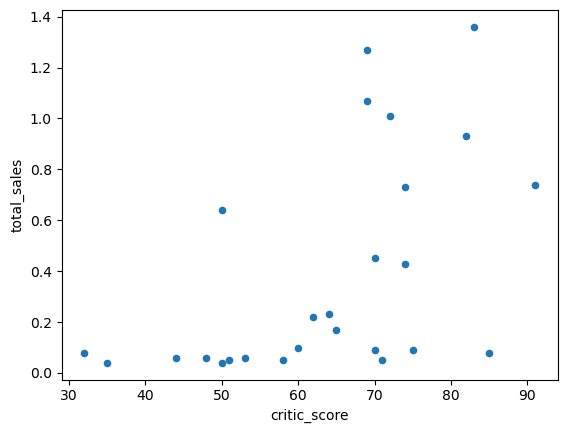

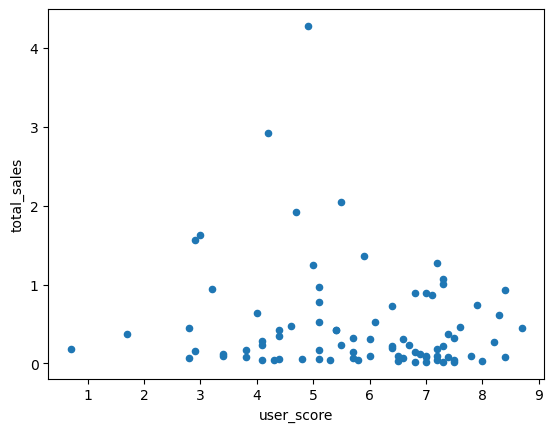

critic_score    0.525723
user_score     -0.138445
total_sales     1.000000
Name: total_sales, dtype: float64

XOne


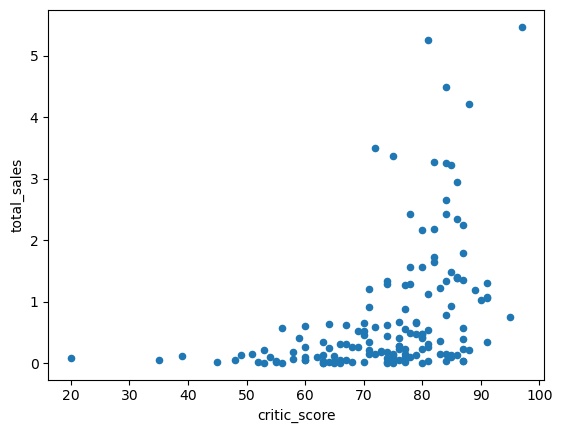

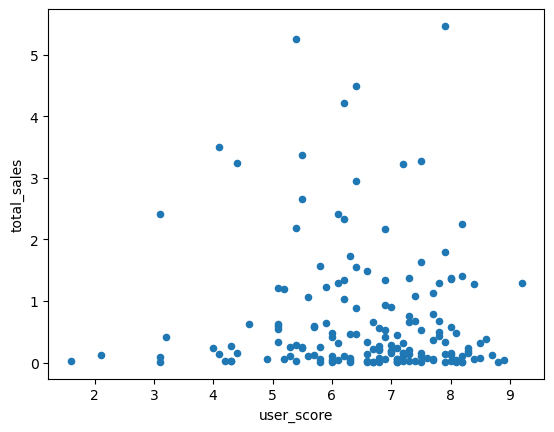

critic_score    0.428677
user_score     -0.070384
total_sales     1.000000
Name: total_sales, dtype: float64

In [70]:
# Построим диаграммы в цикле
df_sc, y = data_actual, 'total_sales'
for platform, games_on_pl in df_sc.groupby('platform'):
    print('='*60)
    print(platform)
    games_on_pl.plot(kind='scatter', x='critic_score', y=y)
    games_on_pl.plot(kind='scatter', x='user_score', y=y)
    plt.show()
    display(games_on_pl[['critic_score', 'user_score', y]].corr()[y])

### 3.9 Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [71]:
# создадим датафрейм с числом игр в каждом жанре и количеством продаж
genre = pd.DataFrame(data_actual.genre.value_counts()) \
    .rename(columns={'genre': 'game_count'})
genre['total_sales'] = data_actual.groupby('genre')["total_sales"].sum()
genre

,game_count,total_sales
Action,619,199.36
Role-Playing,221,101.44
Adventure,185,17.55
Sports,161,109.48
Shooter,128,170.94
Misc,113,37.55
Racing,69,27.52
Fighting,60,28.22
Simulation,44,13.13
Platform,38,18.09


In [72]:
# посмотрим корреляцию числа игр и проданных копий
genre['game_count'].corr(genre['total_sales'])

0.7758945121393662

Жанр `Action` самый популярный по числу игр и количеству продаж. Жанр `Puzzle` имеет самый низкий рейтинг по двум показателям. 

Значение корреляции почти единица. Из статистики выбивается `Shooter`, при небольшом числе игр, продано много копий. С `Adventure` ситуация обратная. Игр много, продаж нет.

Проверим, все ли игровые платформы в жанре `Action` показывают высокий результат продаж, или несколько уникальных игр сделало этот жарн популярным

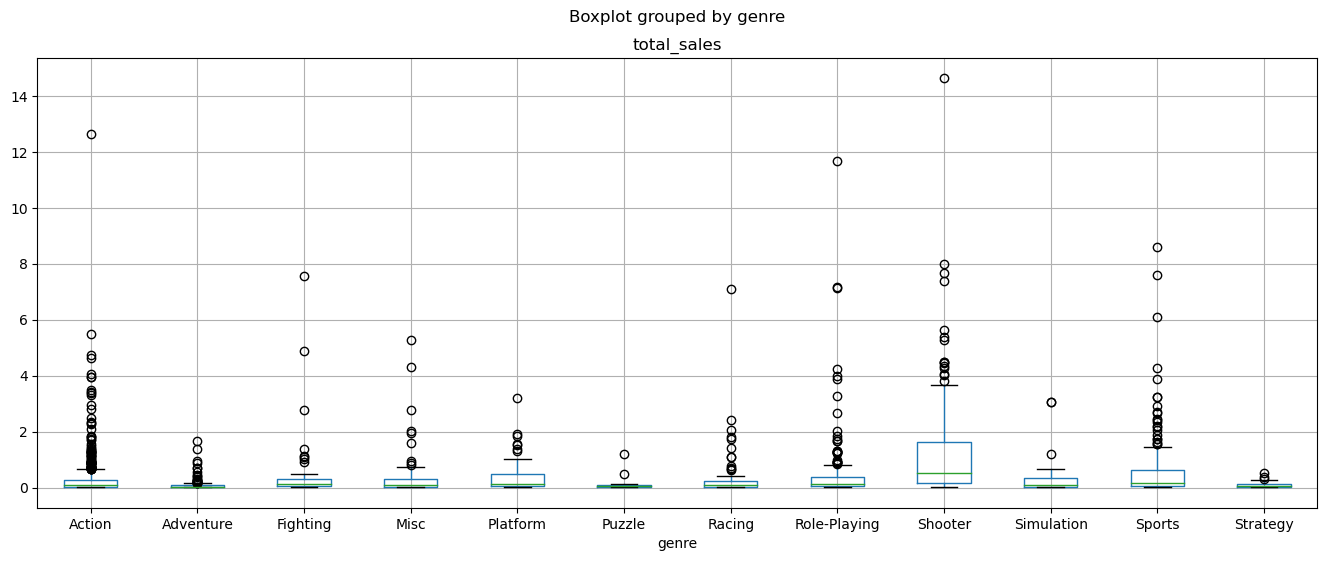

In [73]:
# построим диаграмму размаха
data_actual \
    .boxplot('total_sales', by='genre', figsize=(16, 6));

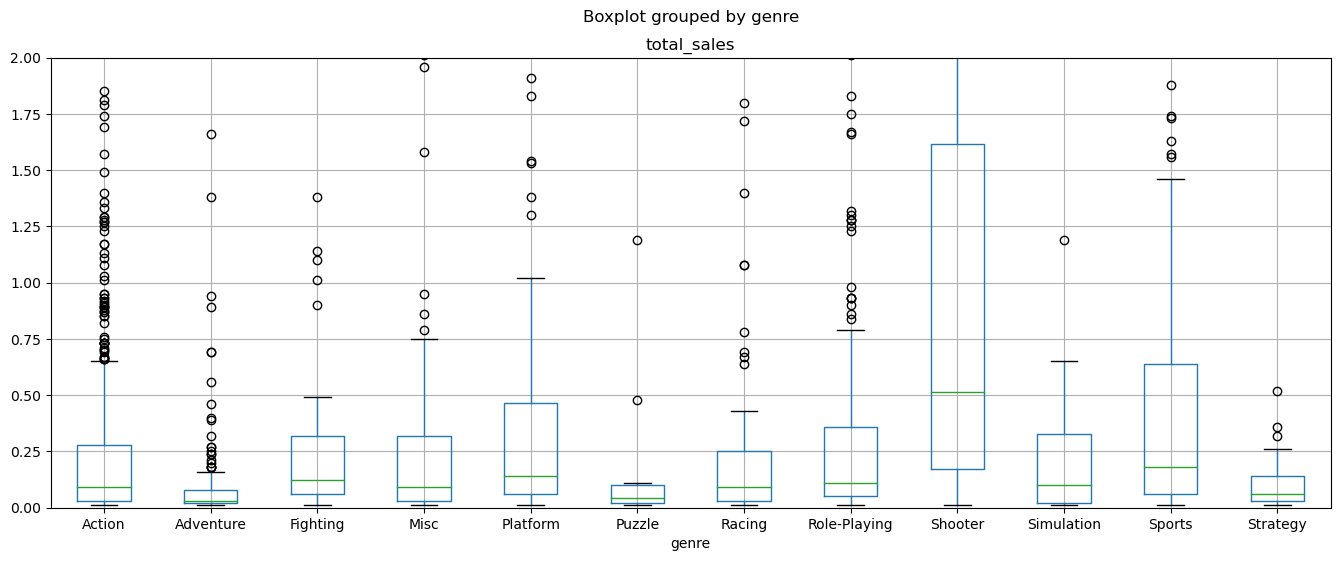

In [74]:
# изменим масштаб, чтоб было видно медианные значеия
data_actual \
    .boxplot('total_sales', by='genre', figsize=(16, 6)) \
    .set_ylim(0, 2);

In [75]:
# получим количество 
print(len(data_actual \
          .query('genre == "Action" and total_sales > 0.5')), 'игр в жанре Action с числом проданных копий более 500 тыс')
print(len(data_actual \
          .query('genre == "Shooter" and total_sales > 0.5')), 'игр в жанре Shooter с числом проданных копий более 500 тыс')

98 игр в жанре Action с числом проданных копий более 500 тыс
64 игр в жанре Shooter с числом проданных копий более 500 тыс


## 4 Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):

-    Самые популярные платформы (топ-5). Опишите различия в долях продаж.
-    Самые популярные жанры (топ-5). Поясните разницу.
-    Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### 4.1 Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [76]:
# top5 платформ в Северной Америке
na = pd.DataFrame(data_actual.groupby('platform')['na_sales'] \
                  .sum().sort_values(ascending=False) \
                  .head() \
                  .reset_index())

# добавим колонку total_sales по общей колонке platform
na = na.merge(year[['platform', 'total_sales']])

# рассчитаем % от мировых продаж
na['%_sales'] = (na['na_sales'] * 100  / na['total_sales']).round(2)
na

,platform,na_sales,total_sales,%_sales
0,PS4,98.61,314.14,31.39
1,XOne,81.27,159.32,51.01
2,X360,28.30,961.24,2.94
3,3DS,22.64,257.81,8.78
4,PS3,22.05,931.34,2.37


In [77]:
# top5 платформ в Европе
eu = pd.DataFrame(data_actual.groupby('platform')['eu_sales'] \
                  .sum().sort_values(ascending=False) \
                  .head() \
                  .reset_index())

# добавим колонку total_sales по общей колонке platform
eu = eu.merge(year[['platform', 'total_sales']])

# рассчитаем % от мировых продаж
eu['%_sales'] = (eu['eu_sales'] * 100  / eu['total_sales']).round(2)
eu

,platform,eu_sales,total_sales,%_sales
0,PS4,130.04,314.14,41.40
1,XOne,46.25,159.32,29.03
2,PS3,25.54,931.34,2.74
3,PC,17.97,255.76,7.03
4,3DS,16.12,257.81,6.25


In [78]:
# top5 платформ в Японии
jp = pd.DataFrame(data_actual.groupby('platform')['jp_sales'] \
                  .sum().sort_values(ascending=False) \
                  .head() \
                  .reset_index())

# добавим колонку total_sales по общей колонке platform
jp = jp.merge(year[['platform', 'total_sales']])

# рассчитаем % от мировых продаж
jp['%_sales'] = (jp['jp_sales'] * 100  / jp['total_sales']).round(2)
jp

,platform,jp_sales,total_sales,%_sales
0,3DS,44.24,257.81,17.16
1,PS4,15.02,314.14,4.78
2,PSV,14.54,53.81,27.02
3,PS3,11.22,931.34,1.20
4,WiiU,7.31,82.19,8.89


Наибольшее число продаж приходится на Северную Америку. Однако, лидирующие платформы на различных континентах отличаются. Самая популярная в Северной Америке платформа `X360` в Европе находится на 3-й строчке, в Японии не вошла в пятёрку популярных. `3DS` занимает первое место Японии. `PS3` первое место в Европе. Почти половина проданных игр для `PS4` приходится на Европу.

Странно, что `PC` вошел в пятёрку лидеров только в Европе и то, на последнем месте.

### 4.2 Самые популярные жанры (топ-5). Поясните разницу.

У нас 12 категорий жанров. Выводить топ-5 по каждому региону не будем. Вручную составим сводную таблицу.

In [79]:
# top5 жанров в Северной Америке
na_genre = pd.DataFrame(data_actual \
                        .groupby('genre')['na_sales'] \
                        .sum().reset_index())

# top5 жанров в Европе
eu_genre = pd.DataFrame(data_actual \
                        .groupby('genre')['eu_sales'] \
                        .sum().reset_index())

# top5 жанров в Японии
jp_genre = pd.DataFrame(data_actual \
                        .groupby('genre')['jp_sales'] \
                        .sum().reset_index())

# сводная таблица по жанрам
pivot_ganre = na_genre.merge(eu_genre, on='genre') \
    .merge(jp_genre, on='genre')

pivot_ganre.sort_values(by='jp_sales', ascending=False)

,genre,na_sales,eu_sales,jp_sales
7,Role-Playing,33.47,28.17,31.16
0,Action,72.53,74.68,29.58
2,Fighting,12.43,6.69,6.37
3,Misc,15.05,12.86,5.61
8,Shooter,79.02,65.52,4.87
1,Adventure,5.64,6.49,3.60
10,Sports,46.13,45.73,3.26
4,Platform,6.79,6.80,2.69
9,Simulation,2.63,7.30,2.31
6,Racing,8.74,14.13,1.76


В Северной Америке и Европе первые три популярных жанра схожие. Лидер в Японии - `Role-Playing`. Далее предпочтения Японцев схожие - `Action`.

In [80]:
# создадим список значений с продажами по NA
values_na = pivot_ganre.na_sales.round(1).sort_values(ascending = False).tolist()
values_na = values_na[:5]
other_na = (pivot_ganre.na_sales.round(1).sort_values(ascending = False)[5:]).sum()
values_na.append(other_na)

# создадим список значений с продажами по EU
values_eu = pivot_ganre.eu_sales.round(1).sort_values(ascending = False).tolist()
values_eu = values_eu[:5]
other_eu = (pivot_ganre.eu_sales.round(1).sort_values(ascending = False)[5:]).sum()
values_eu.append(other_eu)

# создадим список значений с продажами по JP
values_jp = pivot_ganre.jp_sales.round(1).sort_values(ascending = False).tolist()
values_jp = values_jp[:5]
other_jp = (pivot_ganre.jp_sales.round(1).sort_values(ascending = False)[5:]).sum()
values_jp.append(other_jp)

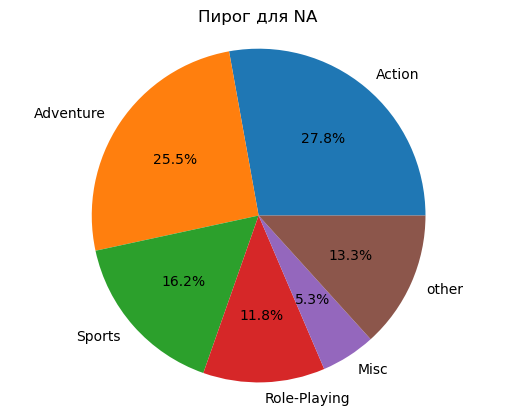

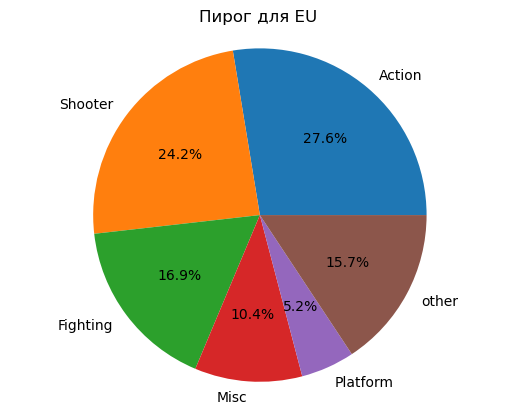

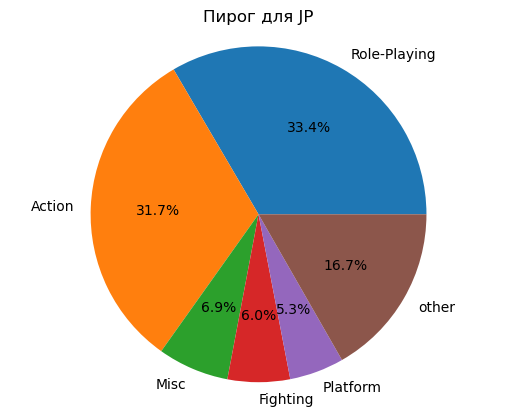

In [81]:
labels_na = ['Action','Adventure','Sports','Role-Playing', 'Misc', 'other']
plt.pie(values_na,labels=labels_na,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Пирог для NA')
plt.show()

labels_eu = ['Action','Shooter','Fighting','Misc', 'Platform', 'other']
plt.pie(values_eu,labels=labels_eu,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Пирог для EU')
plt.show()

labels_jp = ['Role-Playing','Action','Misc','Fighting', 'Platform', 'other']
plt.pie(values_jp,labels=labels_jp,autopct='%1.1f%%')
plt.axis('equal')
plt.title('Пирог для JP')
plt.show()

C:\Users\new-user1\AppData\Local\Temp\ipykernel_26416\2861701077.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_i = df_i.append({'genre': 'Other_genre', countries[i]: games_fresh[countries[i]].sum() - df_i[countries[i]].sum()}, ignore_index= True)
C:\Users\new-user1\AppData\Local\Temp\ipykernel_26416\2861701077.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_i = df_i.append({'genre': 'Other_genre', countries[i]: games_fresh[countries[i]].sum() - df_i[countries[i]].sum()}, ignore_index= True)
C:\Users\new-user1\AppData\Local\Temp\ipykernel_26416\2861701077.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_i = df_i.append({'genre': 'Other_genre', countries[i]: games_fresh[countries[i]].sum() - df_i[coun

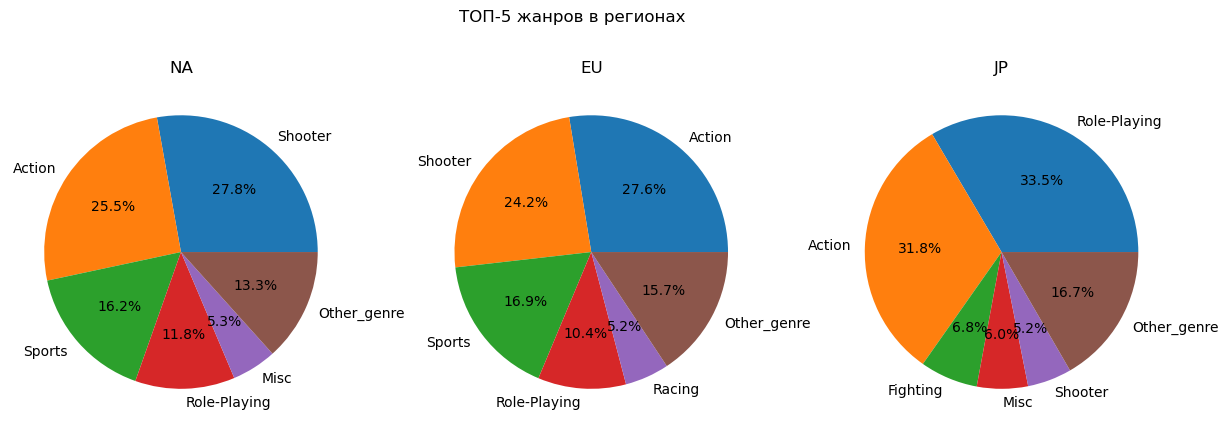

In [82]:
# Горизонтальное расположение
games_fresh = data_actual.copy()
countries = games_fresh.columns[4:7]
# начертим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 жанров в регионах')
for i in range(3):
  # выберем 5 самых продающих жанров
  df_i = (games_fresh.groupby('genre')[countries[i]].sum().
             reset_index().
             sort_values(countries[i], ascending = False, ignore_index = True).
             head(5))
  # занесем все остальыне продажи в другие жанры
  df_i = df_i.append({'genre': 'Other_genre', countries[i]: games_fresh[countries[i]].sum() - df_i[countries[i]].sum()}, ignore_index= True)
  axs[i].pie(df_i[countries[i]], labels = df_i['genre'], autopct='%1.1f%%')
  # Зададим название региона.
  axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

## 5 Проверьте гипотезы

### 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

```
H_0: Пользовательские рейтинги (user_score) платформы "Xbox One" = Пользовательским рейтингам (u_s_copy)  платформы "PC"
H_a: Пользовательские рейтинги (user_score) платформы "Xbox One" ≠ Пользовательским рейтингам (u_s_copy)  платформы "PC"
alpha = 0.05
```

In [83]:
# Для корректного рассчёта удалим строки с пропусками в user_score
data_actual = data_actual[data_actual['user_score'].notna()]
# убедимся, что нет пропусков
data_actual.user_score.isna().sum()

0

In [84]:
results = st.ttest_ind(
    data_actual.loc[data_actual.platform == 'XOne', 'user_score'],
    data_actual.loc[data_actual.platform == 'PC', 'user_score'], 
    equal_var=False)
 
alpha = 0.05
 
print(results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


### 5.2 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.|

```
H_0: Пользовательские рейтинги (user_score) жанра "Action" = Пользовательским рейтингам (u_s_copy) жанра "Sports"
H_a: Пользовательские рейтинги (user_score) жанра "Action" ≠ Пользовательским рейтингам (u_s_copy) жанра "Sports"
alpha = 0.05
```

In [86]:
results = st.ttest_ind(
    data_actual.loc[data_actual.genre == 'Action', 'user_score'],
    data_actual.loc[data_actual.genre == 'Sports', 'user_score'], 
    equal_var=False)
 
alpha = 0.05
 
print(results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.1825550382644557e-14
Отвергаем нулевую гипотезу


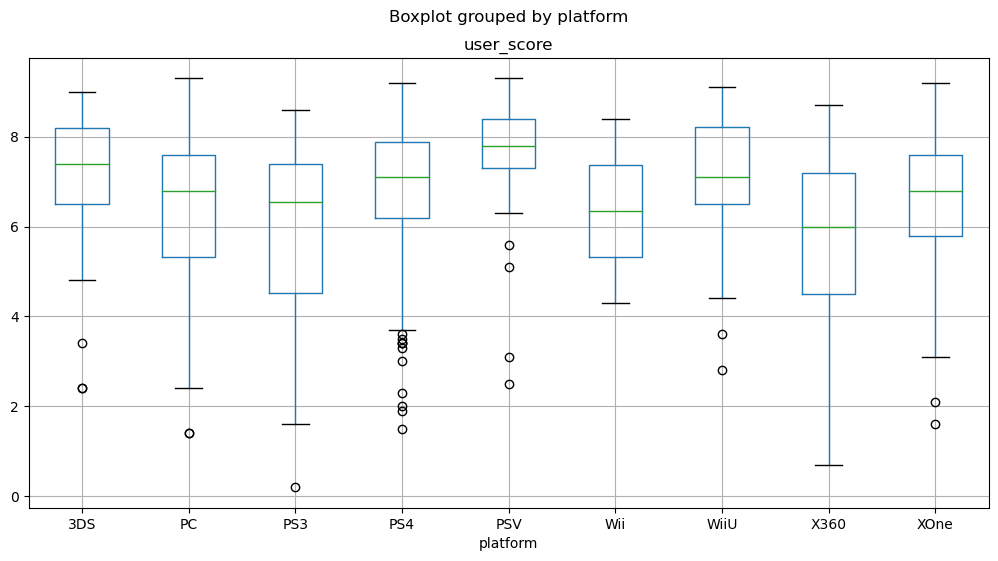

In [87]:
# создадим диаграмму размаха для иллюстрации пользовательских рейтингов по платформам
data_actual.boxplot('user_score', by='platform', figsize=(12, 6));

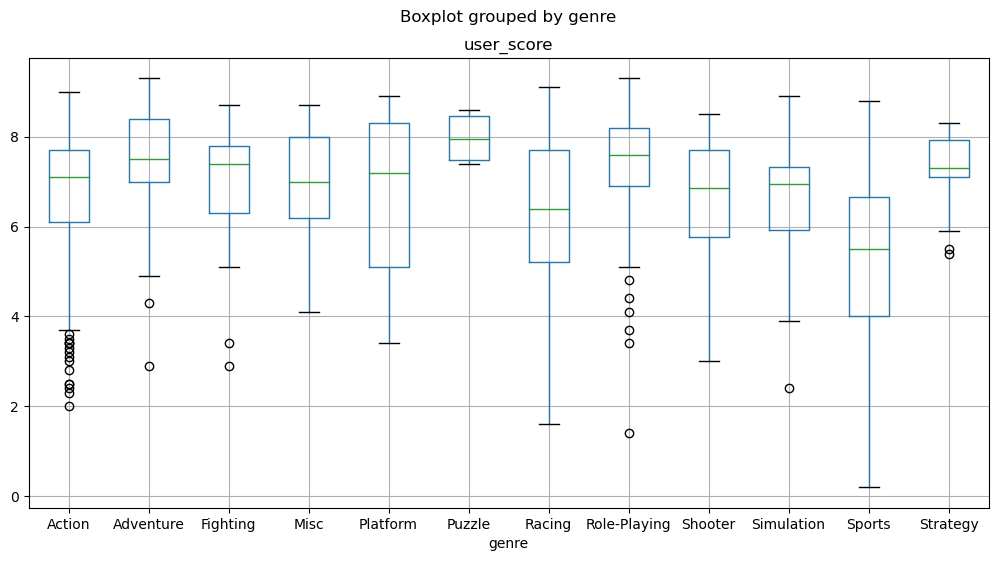

In [88]:
# создадим диаграмму размаха для иллюстрации пользовательских рейтингов по жанрам
data_actual.boxplot('user_score', by='genre', figsize=(12, 6));

Изучим распределение продаж по возрастному рейтингу игр

Распишем значения групп ESRB:

- E - Подходит для всех возрастных категорий.
- E10+ - Подходит для лиц старше 10 лет.
- T - Подходит для лиц старше 13 лет.
- M - Подходит для лиц старше 17 лет.
- RP - Категория ещё не присвоена.

In [89]:
# заменим заглушку unknown на RP
data_actual.loc[(data_actual.rating == 'unknown'), 'rating'] = 'RP'

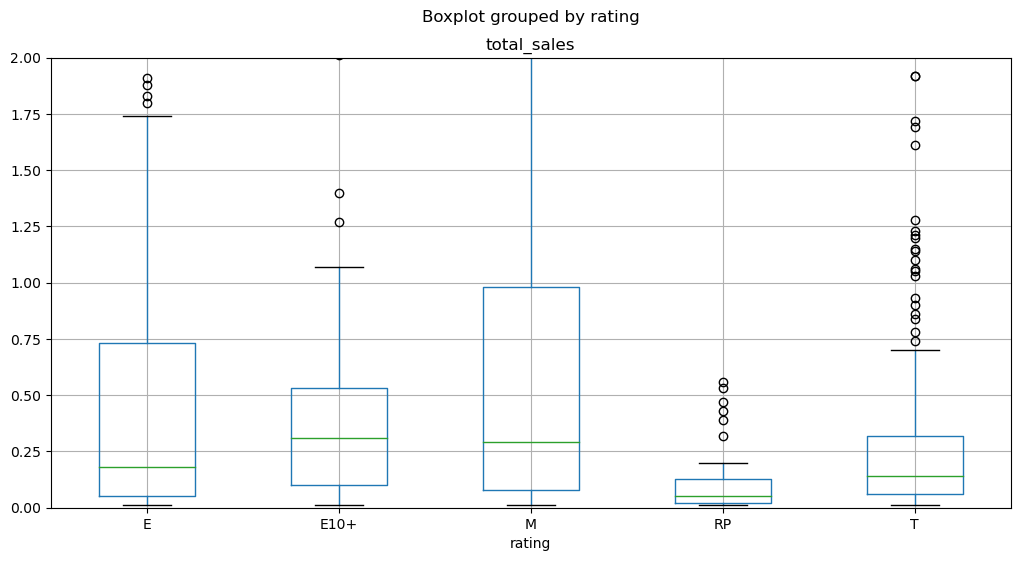

In [90]:
data_actual.boxplot('total_sales', by='rating', figsize=(12, 6)).set_ylim(0,2);

In [91]:
data_actual.groupby('rating')['total_sales'].sum()

rating
E       131.87
E10+     66.26
M       224.63
RP        4.37
T        96.98
Name: total_sales, dtype: float64

## 6 Напишите общий вывод

С каждым годом увеличивается число выпускаемых игр.

Наибольшее число продаж приходится на X360, PS2 и PS3.

Цикл жизни игровой платформы не превышает 10 лет.

В 2016 г. видно падение продаж у всех платформ. Могу предположить, что это связано с ожиданием выхода Xbox Series S и PlayStation 5.

Существует небольшая зависимость рейтинга пользователей/критиков к числу проданных копий.

С наибольшим отрывом в рейтинге популярности лидируют два жанра: Action и Sports.

Самые активные покупатели видео игр нахдятся Северную Америку. Лидирующая платформа - X360.



Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
получена ошибка

Гипотеза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
Подтверждена

Прогноз на 2017 г. Что рекламируем?

Упор делаем на две игровых платформы Xbox One и PS4 (или приходящею ей на смену PS5).

Приоритетные жанры: Action, Shooter, Role-Playing.

Возрастной рейтинг по ESRB - М и Е.